### 03_Trainer : Notebook to load configs, dataloaders, load pretrained model and perform training

In [1]:
import sys
sys.path.append("../")

import random
import numpy as np
import torch

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch import optim
from torch.optim import lr_scheduler
import torch.nn as nn

In [2]:
from backbone.dataset import Face_Dataset_Triplet
from backbone.loss import ContrastiveLoss,TripletLoss
from backbone.networks.inception_resnet_v1 import InceptionResnetV1

Using TensorFlow backend.


### Configs


In [3]:
batch_size = 32
lr = 1e-2
n_epochs = 20
log_interval = 50

### Load the datasets

In [4]:
face_data_train = Face_Dataset_Triplet(root_dir= "../lfw/", file_root = "../files/", train=True)
face_data_val =   Face_Dataset_Triplet(root_dir= "../lfw/", file_root = "../files/", test=True)

### Load the Model (for transfer learning)


In [5]:
Siamese_network = InceptionResnetV1(pretrained='vggface2')
checkpoint = torch.load("../pretrained/20180402-114759-vggface2.pt")
Siamese_network.load_state_dict(checkpoint)
Siamese_network = Siamese_network.cuda()

### Training parameters

In [6]:
criterion = TripletLoss(margin=1.)
optimizer = optim.Adam(Siamese_network.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 4, gamma=0.1, last_epoch=-1)

### Dataloaders

In [7]:
train_dataloader = DataLoader(face_data_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=batch_size)

In [8]:
test_dataloader = DataLoader(face_data_val,
                        shuffle=True,
                        num_workers=8,
                        batch_size=batch_size)

### Train Procedure

In [9]:
from backbone.trainer import train_epoch,validate_epoch,save_model

In [10]:
train_losses = []
val_losses = []
best_loss = np.inf

In [11]:
exp_name = "inception_resnet_V1_pretrained_triplet"

In [12]:
for epoch in range(20):
        
    learning_rate = scheduler.get_lr()
    train_loss = train_epoch(train_dataloader,Siamese_network,criterion,optimizer)
    val_loss = validate_epoch(test_dataloader,Siamese_network,criterion)
    scheduler.step()
    
    if val_loss<best_loss:
        best_loss =  val_loss
        save_model(Siamese_network,exp_name)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print("Epoch Number : {}".format(epoch))
    print("---------------------------------------------------------------")
    print("    Train Loss :{}  , Val_Loss : {} , Learning Rate: {}".format(train_loss,val_loss,learning_rate))
    print("\n")

Epoch Number : 0
---------------------------------------------------------------
    Train Loss :0.9976881954405042  , Val_Loss : 0.7347345139299121 , Learning Rate: [0.01]


Epoch Number : 1
---------------------------------------------------------------
    Train Loss :0.9538144826889038  , Val_Loss : 0.6559733088527407 , Learning Rate: [0.01]


Epoch Number : 2
---------------------------------------------------------------
    Train Loss :0.8966675440470377  , Val_Loss : 0.6494932238544736 , Learning Rate: [0.01]


Epoch Number : 3
---------------------------------------------------------------
    Train Loss :0.8274644533793132  , Val_Loss : 0.6045036890677044 , Learning Rate: [0.01]


Epoch Number : 4
---------------------------------------------------------------
    Train Loss :0.7977578547265795  , Val_Loss : 0.5978392149720874 , Learning Rate: [0.001]


Epoch Number : 5
---------------------------------------------------------------
    Train Loss :0.8273285667101542  , Val_L

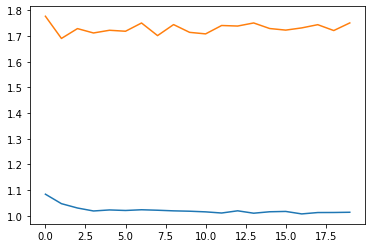

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)